# Tutorial 2: Gaussian Process Model for Regression

In this notebook, we will walk through the functionalities of the developed package related to training and exploiting a Gaussian Process model for regression purposes. 

For using Gaussian Process models to handle regression problems, please take a look at the following paper:

[V. Picheny, T. Wagner, D. Ginsbourger, 2013, A benchmark of kriging-based infill criteria for noisy optimization, *Structural and Multidisciplinary Optimization*, 48(3)](https://doi.org/10.1007/s00158-013-0919-4).

If you have further questions, please contact Shuai Guo at guo@tfd.mw.tum.de

In [20]:
# Set module path
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\GaussianProcess")

In [21]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Import GP interpolation module
from GPRegressor import GPRegressor

%matplotlib inline

## 1. One-dimensional analytical function

In this tutorial, the first reference problem we considered is to approximate a one-dimensional analytical function given noisy observations:

\begin{equation}
y = (6x-2)^2sin(12x-4), x \in [0,1]
\end{equation}

In [22]:
# Define test function
def Test_1D(X):
    """1D Test Function"""
    
    y = (X*6-2)**2*np.sin(X*12-4)
    
    return y

### 1.1 Generate training/testing dataset

In this step, we generate some noisy training data

In [23]:
# Training data
X_train = np.linspace(0.0, 1.0, 20).reshape(-1,1)
y_train = Test_1D(X_train) + np.sqrt(2)*np.random.randn(20,1)

# Testing data
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)
y_test = Test_1D(X_test)

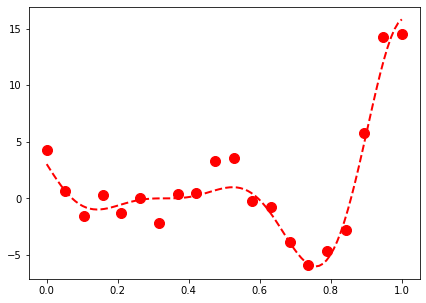

In [24]:
# Visualize training data and reference function
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test, y_test, 'r--', lw=2)
ax.plot(X_train, y_train, 'ro', markersize=10);

### 1.2 Initiate a GPRegressor class

To train a Gaussian Process (GP) model and later use it for performing regression tasks, we first need to initiate a `GPRegressor` class. This class has almost the same parameters as the previous `GPInterpolator` class. Since adjoint-based likelihood gradient calculation has not been implemented yet in the current `GPRegressor` class, the `opt` parameter only specifies the type of the local optimizer. As a result, the model training speed may be slower as each local optimizer may need to run longer to find the optimum. 

In [25]:
GP = GPRegressor(trend='Linear', n_restarts=40)

In [26]:
# Check default attributes
GP.__dict__

{'verbose': False,
 'n_restarts': 40,
 'opt': 'L-BFGS-B',
 'init_point': None,
 'kernel': 'Gaussian',
 'trend': 'Linear',
 'nugget': 1e-10}

### 1.3 GP model training

Next, we call `.fit` method to train a GP model.

In [27]:
# Fit GP model
GP.fit(X_train, y_train)

### 1.4 GP model predicting

Next, we use the newly trained GP model to make predictions at testing samples.

In [28]:
# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)

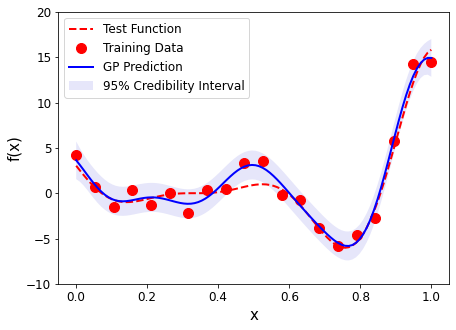

In [29]:
# Assess prediction results
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(X_test,y_pred,'b-', lw=2, label='GP Prediction')
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])
ax.legend(loc="upper left",prop={'size': 12});

We could assess the performance of the trained GP model by calculating the root-mean-square error between the predicted results and the ground truth. This can be done via `.score` method.

In [30]:
GP.score(X_test, y_test)

0.8592125576103241

### 1.5 Generating prediction realizations

Sometimes it is useful to generate realizations of the GP predictions for Monte Carlo simulations. To generate realizations, we treat GP predictions as random variables, following a multivariate normal distribution. Here, we can use `.realizations` method to generate prediction realizations.

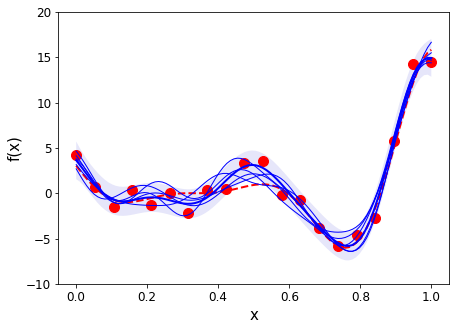

In [31]:
# Generate realizations
samples = GP.realizations(5, X_test)

# Post-processing
fig, ax = plt.subplots(figsize=(7,5))

# True function
ax.plot(X_test,y_test,'r--',linewidth=2)

# Training data
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10)

# Mean prediction
ax.plot(X_test,y_pred,'b-', lw=2)

# Display realizations
for i in range(samples.shape[0]):
    ax.plot(X_test, samples[i,:],'b-', lw=1)

# Display confidence bands
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender')

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20]);

## 2. Two-dimensional analytical function

We further showcase how to train and exploit a GP model for multi-dimensional problems. Here, we consider a task of approximating a two-dimensional analytical function.

\begin{equation}
y = (1-x_1)^2 + (x_2-x_1^2)^2, x_1 \in [-2,2] \; x_2 \in [-1,3]
\end{equation}

In [32]:
# 2D Test function
def Test_2D(X):
    """2D Test Function"""
    
    y = (1-X[:,0])**2 + (X[:,1]-X[:,0]**2)**2
    
    return y

### 2.1 Training/testing dataset

We use **Latin Hypercube Sampling** approach to generate space-filling training samples. For the current case, we use the implementation from [`PyDOE`](https://pythonhosted.org/pyDOE/randomized.html#latin-hypercube) package. Alternatively, you could use [skopt.sampler](https://scikit-optimize.github.io/stable/auto_examples/sampler/initial-sampling-method.html#sphx-glr-auto-examples-sampler-initial-sampling-method-py) package. 

In [33]:
# Training data
sample_num = 30
lb, ub = np.array([-2, -1]), np.array([2, 3])
X_train = (ub-lb)*lhs(2, samples=sample_num) + lb

# Compute labels
y_train = Test_2D(X_train).reshape(-1,1) + np.sqrt(5)*np.random.rand(sample_num, 1)

# Test data
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y_test = Test_2D(X_test)

Demonstrate training samples in 2D space

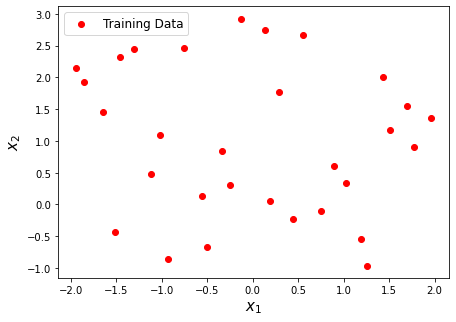

In [34]:
# Vislauzing training samples
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train[:,0], X_train[:,1], c='r', label='Training Data')
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
ax.legend(loc="upper left",prop={'size': 12});

### 2.2 GP model training

As in the previous example, we could use `.fit` method to train a GP model. However, we notice that both $x_1$ and $x_2$ are not varying within 0 and 1. To facilitate robust GP model parameter estimation, a common practice is to normalize the inputs such that they vary in $[0,1]$. Here, we use `sklearn.Pipeline` to glue together a scaler (which scales the inputs) and our developed `GPRegressor` class. 

In [35]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPRegressor(trend='Const', kernel='Gaussian', 
                               opt='L-BFGS-B',
                               n_restarts=30))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('GP', <GPRegressor.GPRegressor object at 0x0000023DB4A74D60>)])

### 2.3 GP model prediction

Then, we make predictions on the test dataset.

In [36]:
# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(X_test)

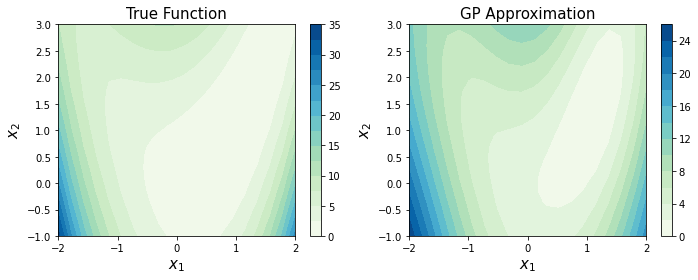

In [37]:
# Post-processing - Contour plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))
title = ['True Function', 'GP Approximation']
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   display_y[i].reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])
plt.tight_layout()

In [38]:
# Assess accuracy score
pipe.score(X_test, y_test)

1.653790622086387